In [1]:
import sys
from tqdm import tqdm

import torch
import torchvision
from torch.nn.utils import vector_to_parameters, parameters_to_vector

import nnj
from pytorch_laplace.hessian.mse import MSEHessianCalculator
from pytorch_laplace.laplace.diag import DiagLaplace

sys.path.append("../")
from plotting_fun import plot_latent, plot_reconstruction_with_latent, plot_std, plot_fancy_latent, plot_attention, plot_training

torch.manual_seed(0)

### Boring dataset stuff

In [2]:
dataset = torchvision.datasets.MNIST('../../../../data/', train=True, download=True,
                             transform=torchvision.transforms.ToTensor()
)
dataset_test = torchvision.datasets.MNIST('../../../../data/', train=False, download=True,
                             transform=torchvision.transforms.ToTensor()
)

def get_batch(dataset, batch_size):
    datas, targets = [], []
    for i in range(batch_size):
        img, t = dataset.__getitem__(i)
        target = torch.zeros(10)
        target[t] = 1 #one-hot-encoded targets
        datas.append(img)
        targets.append(target)
    datas = torch.stack(datas, dim=0)
    targets = torch.stack(targets, dim=0)
    return datas, targets

imgs, labels = get_batch(dataset, 100) #train with 100 images
imgs_test, labels_test = get_batch(dataset_test, 100) #test with 100 images

100%|██████████| 9912422/9912422 [00:00<00:00, 13446806.78it/s]


Extracting ../../../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../../../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45048603.13it/s]


Extracting ../../../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../../../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 13661640.72it/s]


Extracting ../../../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../../../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 25099510.89it/s]


Extracting ../../../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../../../data/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 14066925.02it/s]


Extracting ../../../../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../../../../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45471356.54it/s]


Extracting ../../../../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../../../../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 13854004.62it/s]


Extracting ../../../../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../../../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21623755.70it/s]

Extracting ../../../../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../../../datasets/MNIST/raw



### Model

In [3]:
_latent_size = 2

def get_model():
        encoder = nnj.Sequential(
                nnj.Flatten(),
                nnj.Linear(28*28, 50),
                nnj.Tanh(),
                nnj.Linear(50, _latent_size),
                nnj.L2Norm(),
                add_hooks = True
        )

        decoder = nnj.Sequential(
                nnj.Flatten(),
                nnj.Linear(_latent_size, 50),
                nnj.Tanh(),
                nnj.Linear(50, 28*28),
                nnj.Reshape(1, 28, 28),
                add_hooks = True
        )

        model = nnj.Sequential(
                encoder,
                decoder,
                add_hooks = True
        )
        
        return encoder, decoder, model
encoder, decoder, model = get_model()

encoder_size = len(parameters_to_vector(encoder.parameters()))
decoder_size = len(parameters_to_vector(decoder.parameters()))

# Laplace Online

In [4]:
_epoch_num = 1000
_learning_rate = 0.05
_memory_factor = 0.005
_prior_prec = 0.01  # weight of the l2 regularizer
_sampler_precision_multiplier = 1000
_samples_num = 50

encoder, decoder, model = get_model()
mse = MSEHessianCalculator(wrt="weight", shape="diagonal", speed="half")
sampler = DiagLaplace()

# initialize gaussian on the weight as isotropic N(0,1)
mean = parameters_to_vector(model.parameters())
precision = _prior_prec * torch.ones_like(mean)

# train
losses, losses_test, priors = [], [], []
with torch.no_grad():
    for epoch in tqdm(range(_epoch_num)):
        # (Mean Squared Error + l2 reg)
        # loss = 
        #  = - log p(y,theta) 
        #  = - log p(y|theta) - log p(theta)
        #  = - log_gaussian - log_prior

        # 0-order
        log_gaussian = mse.compute_loss(imgs, imgs, model).detach().numpy()
        log_gaussian_test = mse.compute_loss(imgs_test, imgs_test, model).detach().numpy()
        log_prior = 0.5 * _prior_prec * torch.sum(mean**2).detach().numpy()
        losses.append(log_gaussian + log_prior); losses_test.append(log_gaussian_test + log_prior)
        priors.append(log_prior)

        # 1-order
        gradient_avg = torch.zeros_like(mean)
        std_deviation = 1.0 / (precision * _sampler_precision_multiplier).sqrt()
        samples = sampler.sample(mean, std_deviation, n_samples=_samples_num)
        for parameter in samples: # montecarlo approximate the expected value
            vector_to_parameters(parameter, model.parameters())
            gradient_log_gaussian = mse.compute_gradient(imgs, imgs, model) 
            gradient_log_prior = _prior_prec * parameter
            gradient = gradient_log_gaussian + gradient_log_prior
            gradient_avg += gradient
        gradient_avg /= _samples_num

        # 2-order
        vector_to_parameters(mean, model.parameters())
        hessian = mse.compute_hessian(imgs, model)

        # update gaussian on weights
        mean -= _learning_rate * gradient_avg # gradient step
        precision = (1-_memory_factor) * precision + hessian # laplace step

        vector_to_parameters(mean, model.parameters())

plot_training(losses, losses_test, priors)

 36%|███▋      | 364/1000 [02:55<05:07,  2.07it/s]

### Look at posterior on weights

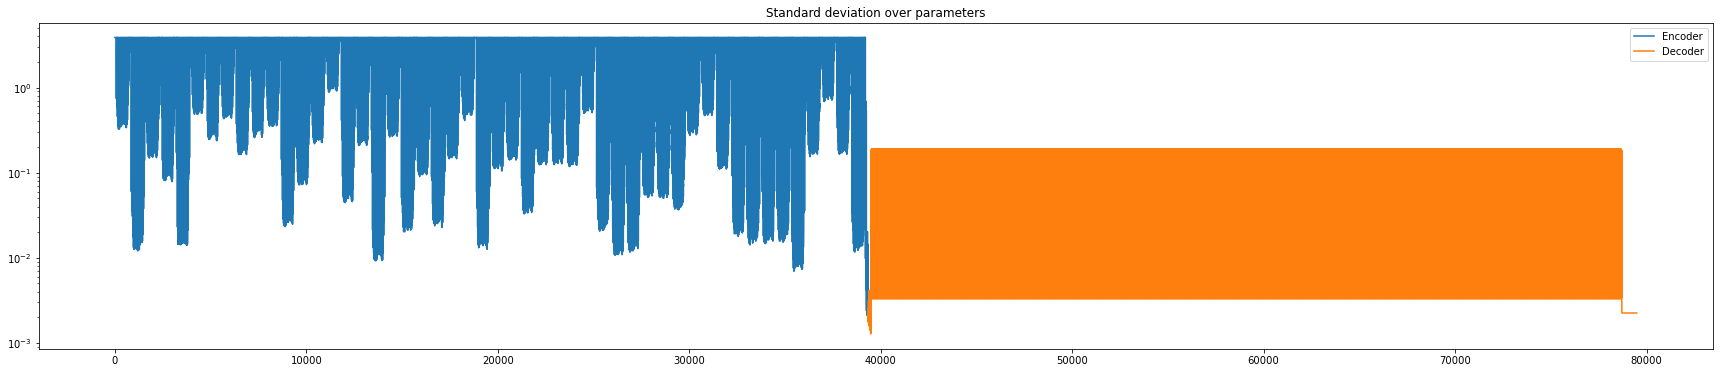

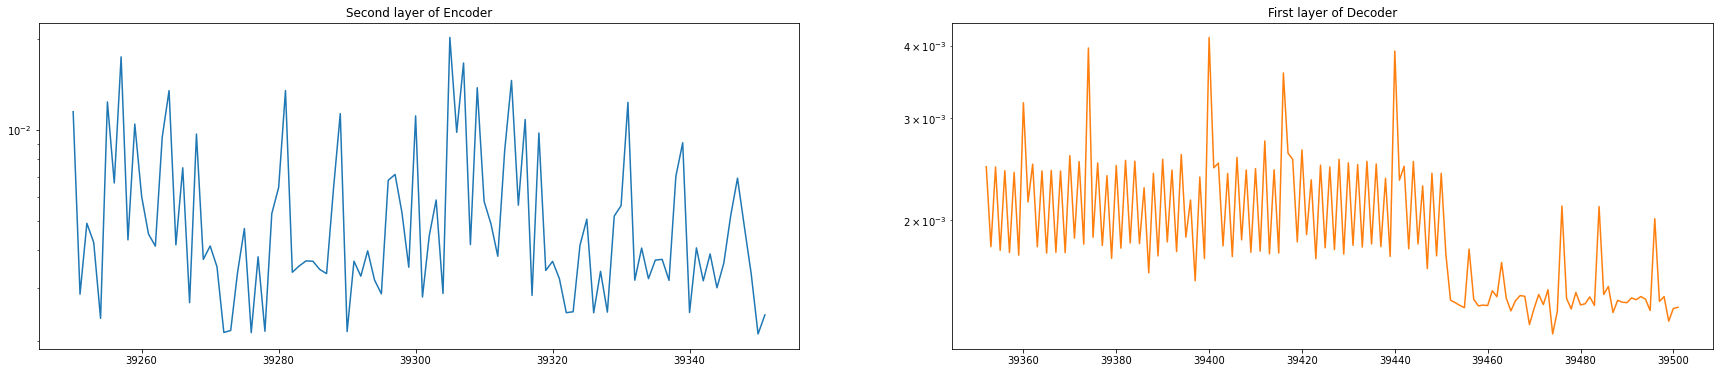

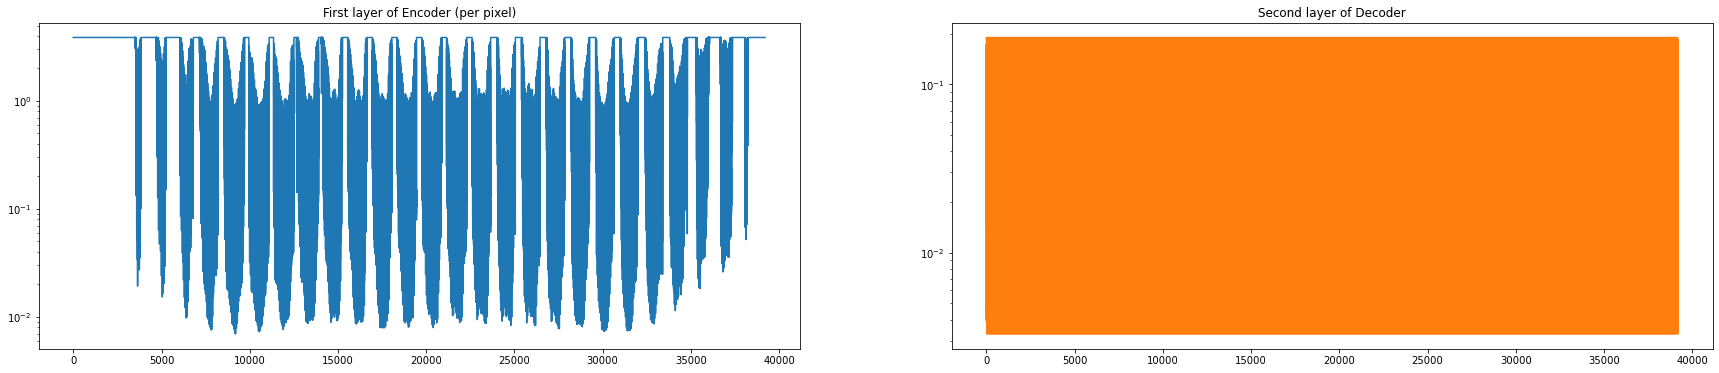

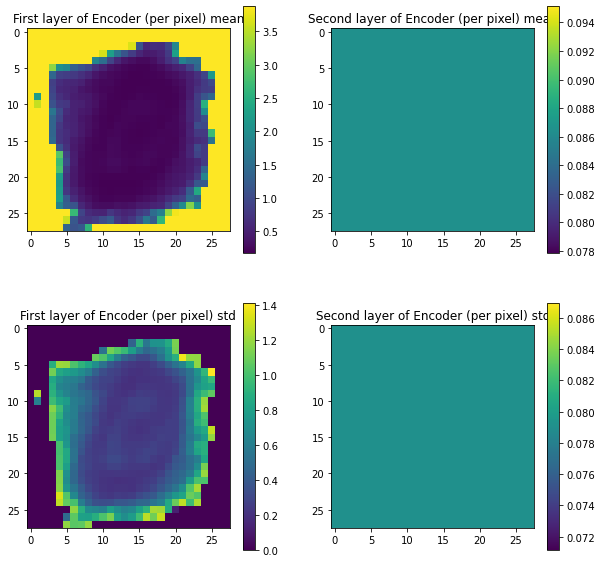

In [ ]:
std_deviation = 1.0 / (precision * _sampler_precision_multiplier).sqrt()

plot_std(std_deviation, encoder_size, decoder_size)
plot_attention(std_deviation)

### Train plots

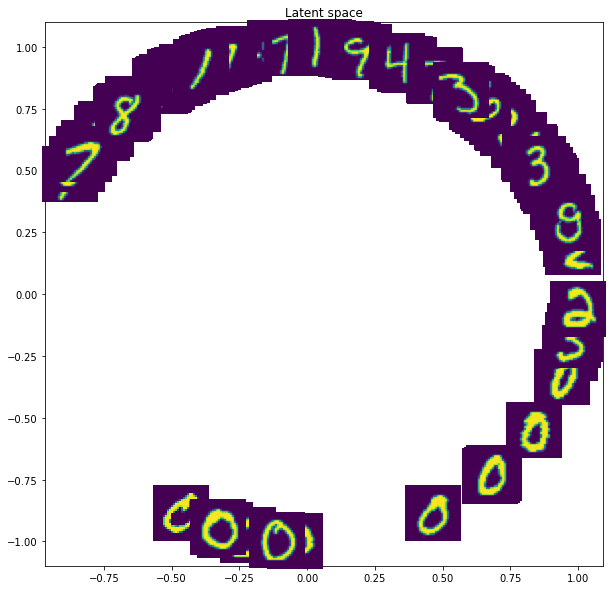

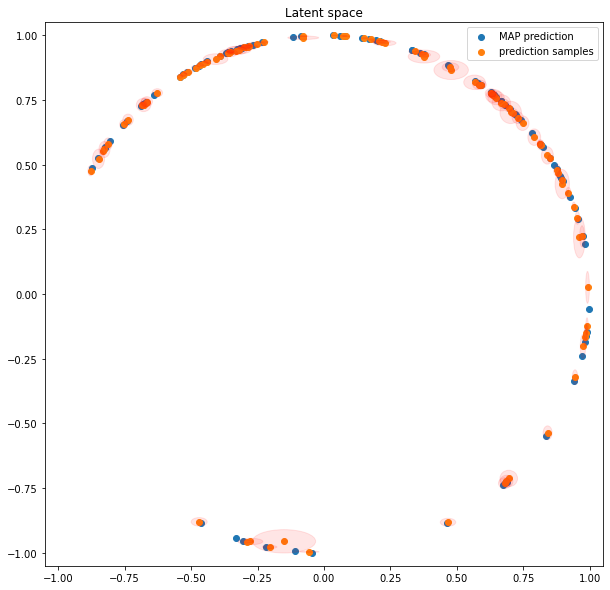

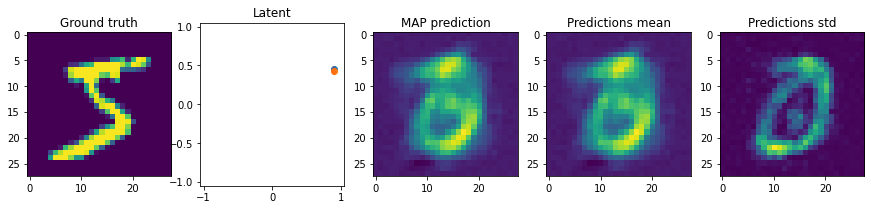

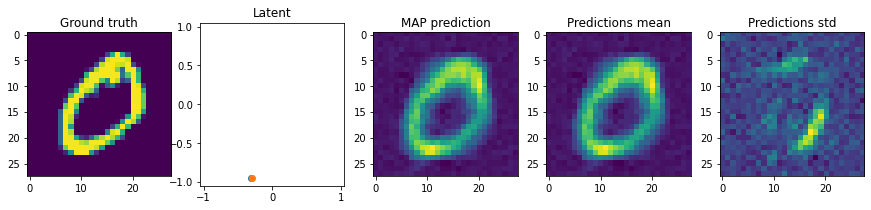

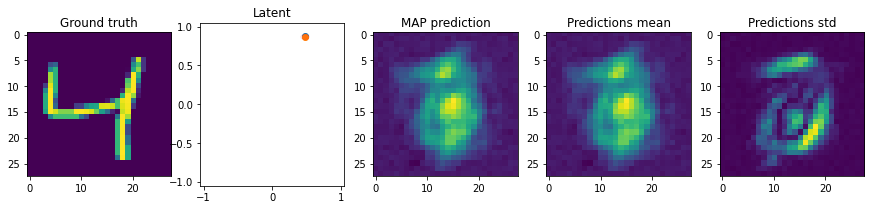

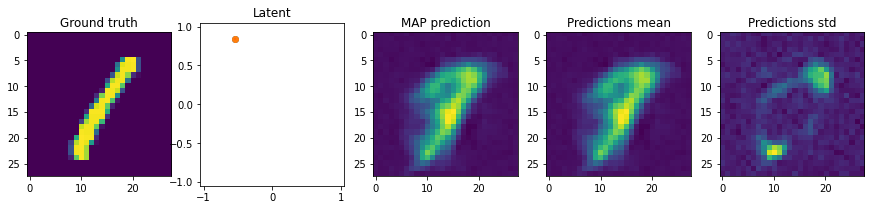

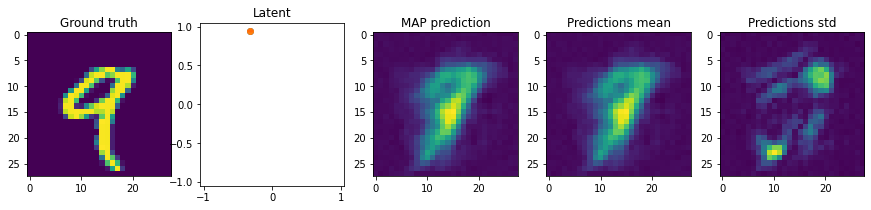

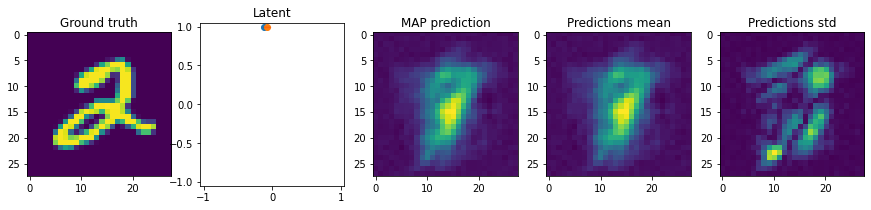

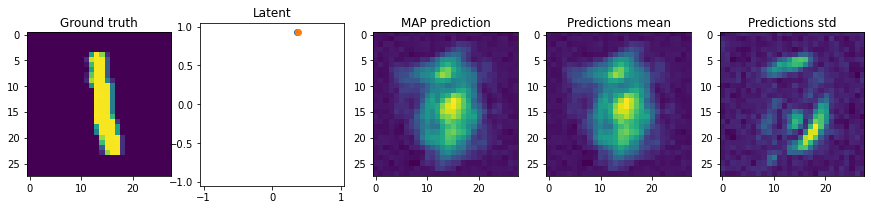

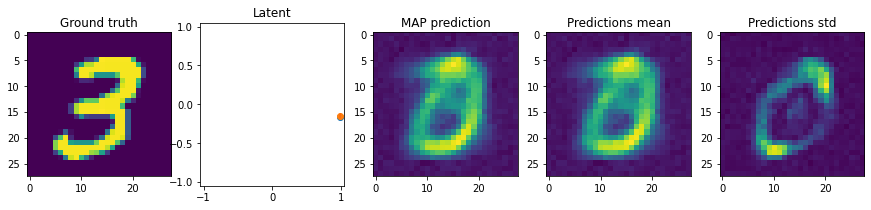

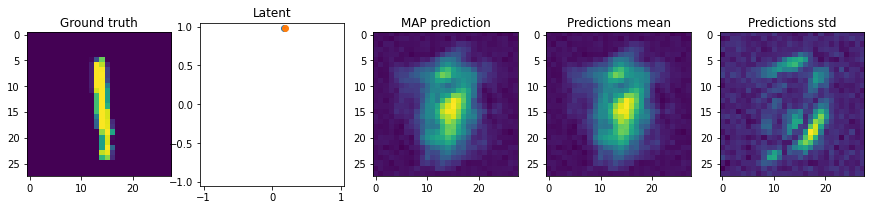

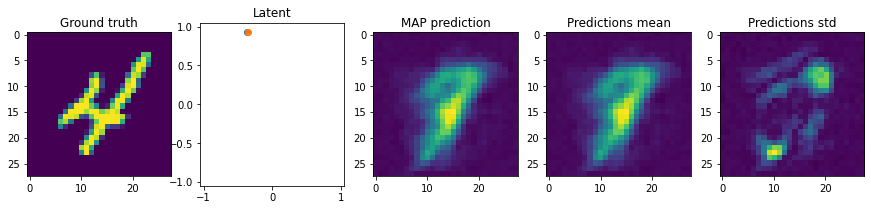

In [ ]:
plot_fancy_latent(encoder, imgs)

encoder_mean = mean[:encoder_size]
encoder_std = std_deviation[:encoder_size]
plot_latent(encoder, imgs, 
            posterior=(encoder_mean, encoder_std),
            scale_radius=1,
            n_sample=1000)

for data_idx in range(10): #only show the first 10 images
    plot_reconstruction_with_latent(model, imgs, 
                        posterior=(mean, std_deviation), 
                        data_idx=data_idx,
                        scale_radius=1, n_sample=1000)

### Test plots

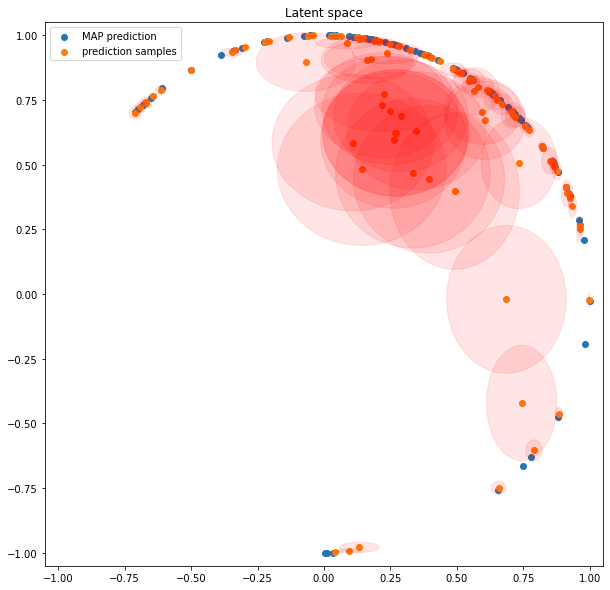

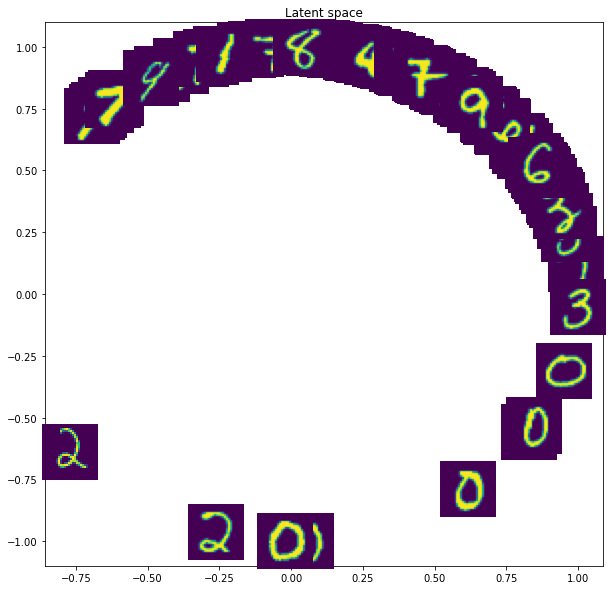

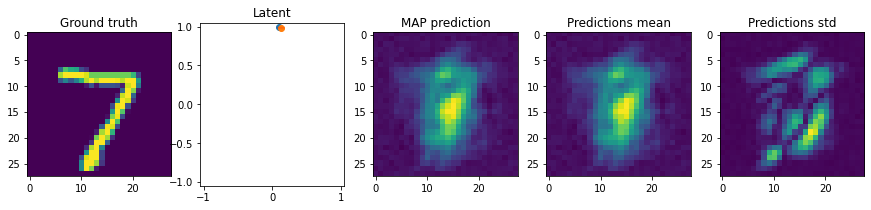

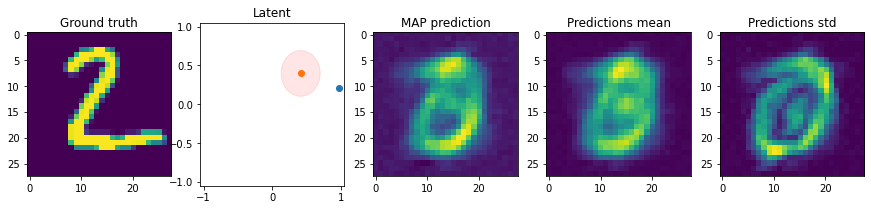

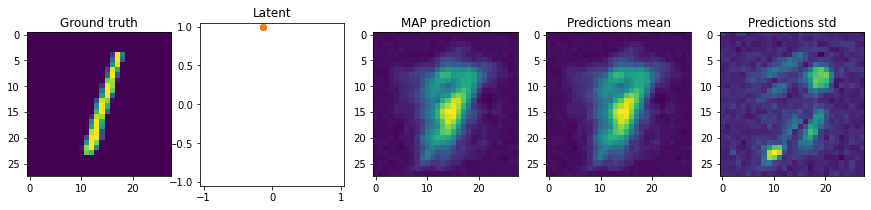

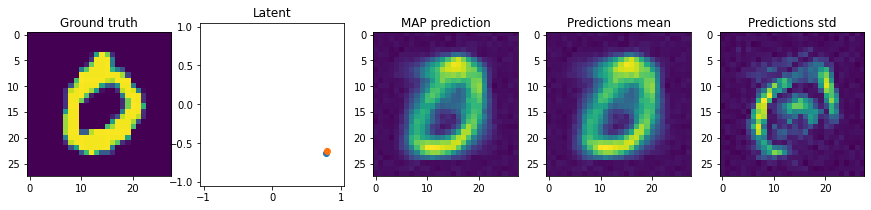

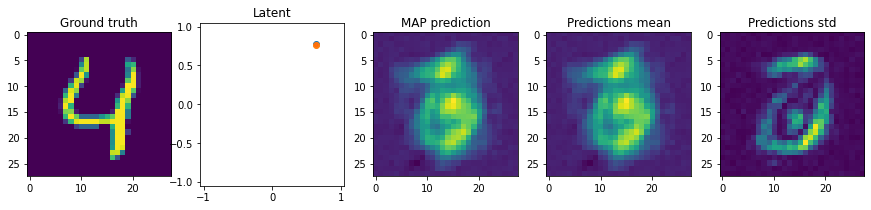

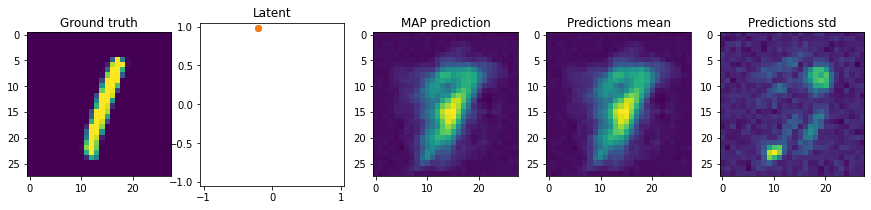

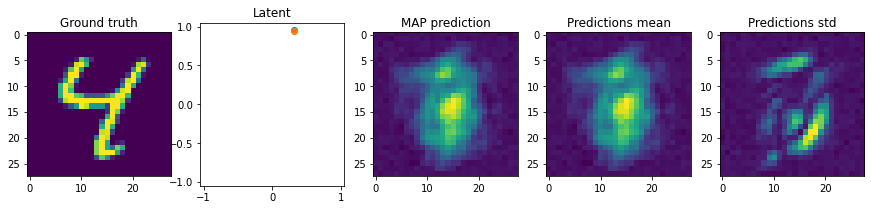

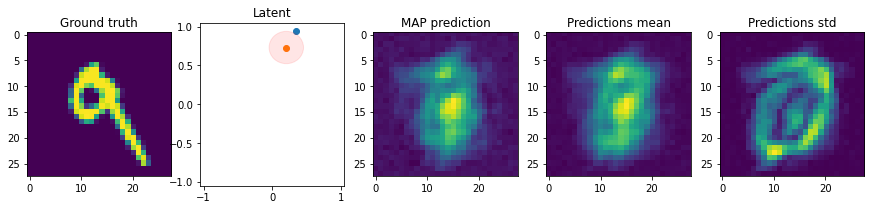

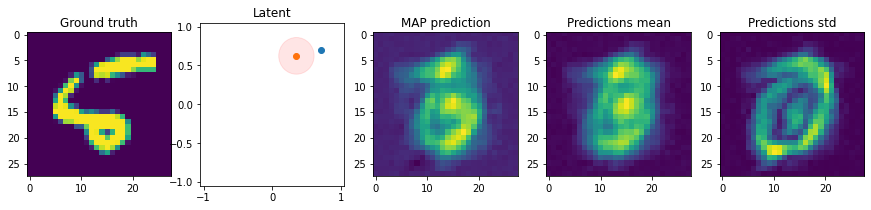

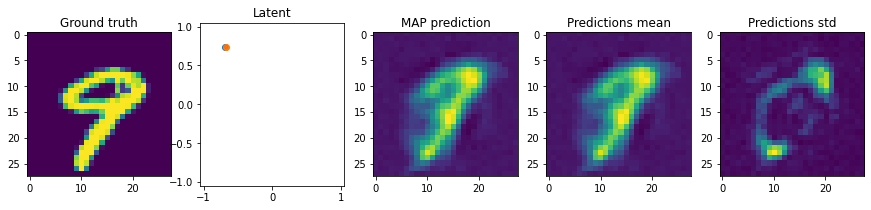

In [ ]:
encoder_mean = mean[:encoder_size]
encoder_std = std_deviation[:encoder_size]

plot_latent(encoder, imgs_test, 
            posterior=(encoder_mean, encoder_std),
            scale_radius=1,
            n_sample=1000)
plot_fancy_latent(encoder, imgs_test)

for data_idx in range(10): #only show the first 10 images
    plot_reconstruction_with_latent(model, imgs_test, 
                        posterior=(mean, std_deviation), 
                        data_idx=data_idx,
                        scale_radius=1, n_sample=1000)

# Sample only the encoder (fix the decoder)

In [ ]:
std_deviation[-decoder_size:] = torch.zeros(decoder_size)

### Train plots

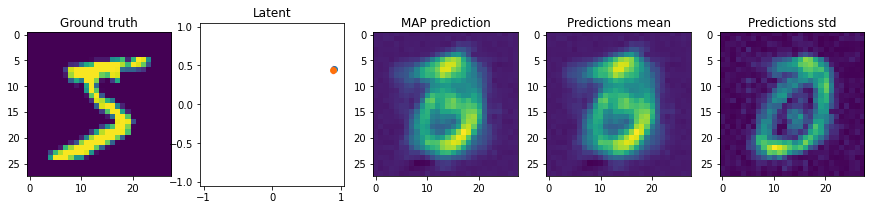

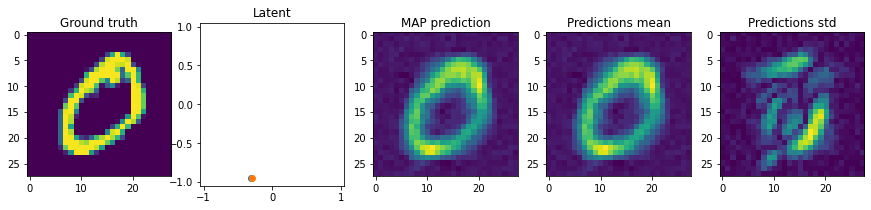

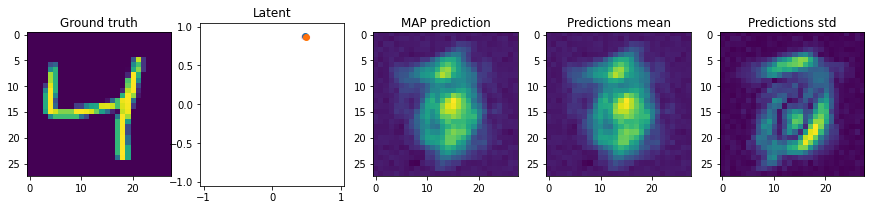

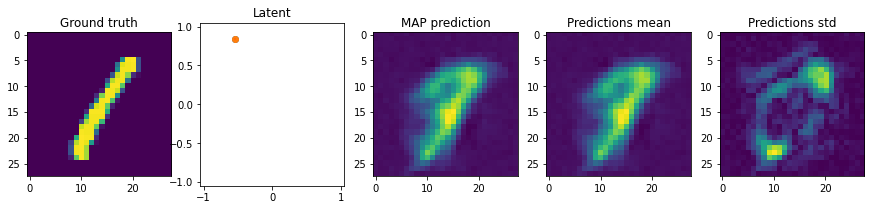

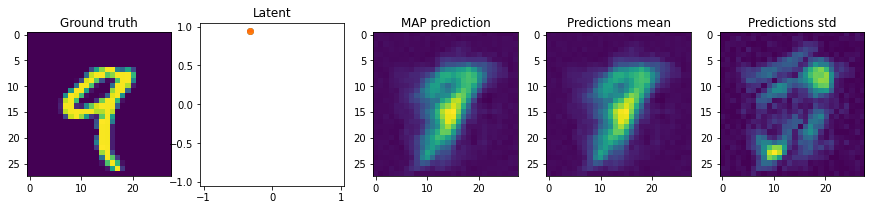

In [ ]:
for data_idx in range(5): #only show the first 5 images
    plot_reconstruction_with_latent(model, imgs, 
                        posterior=(mean, std_deviation), 
                        data_idx=data_idx,
                        scale_radius=1, n_sample=1000)

### Test plots

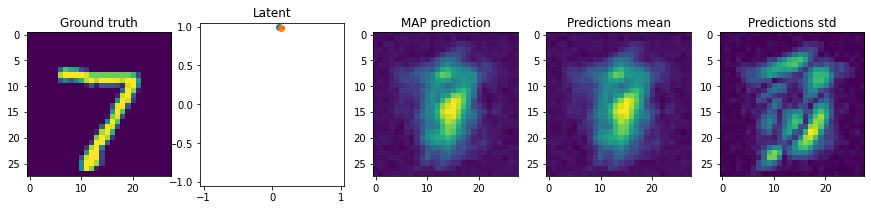

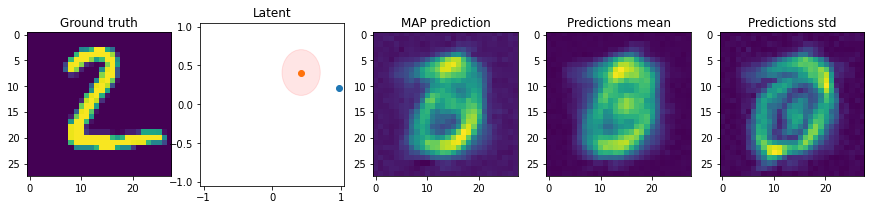

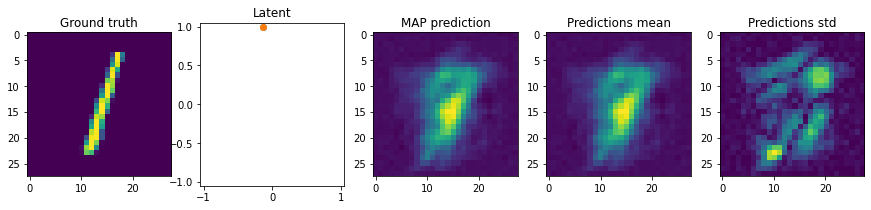

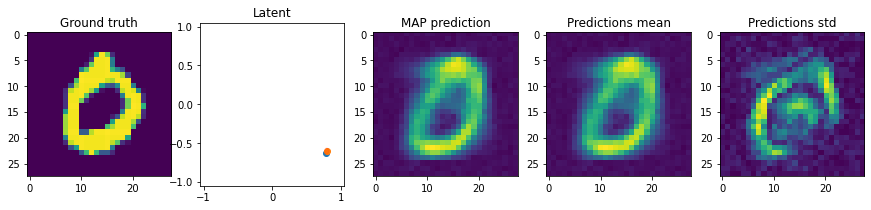

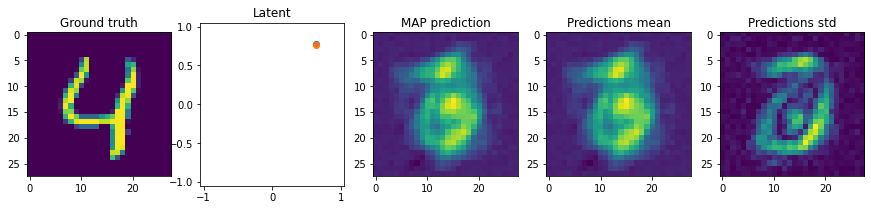

In [ ]:
for data_idx in range(5): #only show the first 5 images
    plot_reconstruction_with_latent(model, imgs_test, 
                        posterior=(mean, std_deviation), 
                        data_idx=data_idx,
                        scale_radius=1, n_sample=1000)